# Library + Function

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Parse time function

In [2]:
def parse_time(df, time_col='time'):
    """
    Mengonversi kolom waktu ke format datetime, mendukung format ISO8601.
    Tidak perlu manual hapus milidetik atau zona waktu.

    Parameters:
    - df: DataFrame yang mengandung kolom waktu.
    - time_col: Nama kolom waktu (default: 'time').

    Returns:
    - df dengan kolom waktu sudah dalam datetime.
    """
    df = df.copy()

    # Parsing dengan dukungan ISO8601
    df[time_col] = pd.to_datetime(df[time_col], format='ISO8601', errors='coerce')

    # Validasi parsing
    invalid = df[df[time_col].isna()]
    if not invalid.empty:
        print("⚠️ Data gagal diparse:")
        print(invalid[[time_col]])
    else:
        print("✅ Semua data berhasil diparse.")

    return df

Magnitude unit conversion function

In [3]:
def conversion(row):
  if row['magType'] == 'mb' and 3.7 <= row['mag'] <= 8.2:
    m = 1.0107*row['mag']+0.0801
  elif row['magType'] == 'ms' and 2.8 <= row['mag'] <= 6.1:
    m = 0.6016*row['mag']+2.4760
  elif row['magType'] == 'ms' and 6.2 <= row['mag'] <= 8.7:
    m = 0.9239*row['mag']+0.5671
  elif row['magType'] == 'md' and 3 <= row['mag'] <= 5.8:
    m = 0.7170*row['mag']+1.003
  else:
    m = row['mag']
  return m

Statistic descriptive function

In [4]:
def desc_stat(df):
    # Menampilkan waktu terkecil dan terbesar
    min_time = df['time'].min()
    max_time = df['time'].max()
    
    print(f"Waktu terkecil: {min_time}")
    print(f"Waktu terbesar: {max_time}")
    
    # Menghitung statistik deskriptif
    numerical_columns = df[['latitude', 'longitude', 'depth', 'mag']]
    descriptive_stats = numerical_columns.describe()
    
    print("\nDescriptive Stats:")
    print(descriptive_stats)
    
    print("\nBanyaknya kolom dan baris:")
    print(df.shape)

Function to determined the distance

In [5]:
from math import sin, cos, sqrt, atan2, radians, asin

def distance (lat_1, lon_1, lat_2, lon_2) :
  R = 6371.0 # Radius bumi

  lat1 = radians (lat_1)
  lon1 = radians (lon_1)
  lat2 = radians (lat_2)
  lon2 = radians (lon_2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin (dlat / 2)**2 + cos(lat1) * cos (lat2) * sin (dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1-a))

  return R*c

Function to change array to list

In [6]:
def unique (list1) :
  x = np.array(list1)
  r = np.unique(x).tolist()
  return r

Declustering function

In [7]:
def declustering(df):
    # Konversi magnitudo dan urutkan data
    df['mag'] = df.apply(conversion, axis=1)
    df = df.sort_values(by=['mag'], ascending=False, ignore_index=True)
    
    # Konversi waktu ke datetime dan tambahkan kolom tambahan
    df['time'] = pd.to_datetime(df['time'], format='%Y/%m/%d %H:%M:%S')
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    df['date'] = df['time'].dt.date
    
    # Array untuk menyimpan indeks gempa yang bukan mainshock
    nonmain = []
    
    for i in range(len(df) - 1):  # Iterasi untuk setiap gempa
        # Hitung jarak pengaruh berdasarkan magnitudo
        d = 10 ** (0.1238 * df['mag'][i] + 0.983)
        
        # Hitung waktu pengaruh berdasarkan magnitudo
        if df['mag'][i] >= 6.5:
            t = 10 ** (0.032 * df['mag'][i] + 2.7389)
        else:
            t = 10 ** (0.5409 * df['mag'][i] - 0.547)
        
        for j in range(i + 1, len(df)):  # Iterasi untuk gempa berikutnya
            # Hitung selisih tanggal
            date1 = df['date'][i]
            date2 = df['date'][j]
            tim = (date2 - date1).days  # Hasil selisih tanggal (positif/negatif)
            
            if tim < 0:  # Jika tanggal `j` lebih awal dari `i`
                continue  # Langsung lanjut ke gempa berikutnya (anggap mainshock)
            
            # Hitung jarak antar gempa
            dis = distance(df['latitude'][i], df['longitude'][i], df['latitude'][j], df['longitude'][j])
            
            # Jika memenuhi kriteria jarak dan waktu pengaruh, tambahkan ke nonmain
            if tim < t and dis < d:
                nonmain.append(j)
    
    # Hapus gempa yang bukan mainshock dari dataset
    df.drop(unique(nonmain), axis=0, inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    return df

# Megathrust Selat Sunda (M7)

In [8]:
df7 = pd.read_csv('../Data/Data M7.csv')

In [9]:
df7

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024/12/20 18:22:39.340+00,-6.4479,105.0901,54.956,5.00,mww,145.0,41.0,2.734,0.93,...,2025/02/27 17:30:53.040+00,"82 km W of Labuan, Indonesia",earthquake,7.33,4.696,0.103,9.0,reviewed,us,us
1,2024/11/29 16:13:17.112+00,-7.6434,104.8551,10.000,4.70,mb,39.0,146.0,2.777,1.19,...,2025/02/02 00:53:35.040+00,"176 km SW of Labuan, Indonesia",earthquake,7.62,1.883,0.095,34.0,reviewed,us,us
2,2024/10/08 14:12:08.786+00,-7.6107,106.5374,38.155,4.90,mb,103.0,51.0,1.113,1.11,...,2024/12/23 15:46:05.040+00,"68 km S of Pelabuhanratu, Indonesia",earthquake,6.01,6.606,0.060,94.0,reviewed,us,us
3,2024/09/16 22:50:48.232+00,-6.9882,105.4400,51.748,4.30,mb,23.0,132.0,2.243,1.12,...,2024/11/23 23:27:40.040+00,"80 km SSW of Labuan, Indonesia",earthquake,8.40,6.808,0.168,10.0,reviewed,us,us
4,2024/09/16 21:46:25.680+00,-6.9441,106.0941,31.155,4.30,mb,28.0,63.0,1.627,0.38,...,2024/11/23 23:27:39.040+00,"50 km W of Pelabuhanratu, Indonesia",earthquake,8.82,4.652,0.119,20.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,1930/06/19 13:27:03.950+00,-6.6560,104.5980,15.000,6.10,mw,NaN,NaN,NaN,NaN,...,2022/04/25 22:29:45.335+00,"139 km WSW of Labuan, Indonesia",earthquake,NaN,15.200,0.200,NaN,reviewed,iscgem,iscgem
598,1930/04/27 09:56:33.490+00,-7.8070,106.4600,35.000,5.68,mw,NaN,NaN,NaN,NaN,...,2022/04/25 22:27:20.724+00,"91 km S of Pelabuhanratu, Indonesia",earthquake,NaN,25.000,0.200,NaN,reviewed,iscgem,iscgem
599,1924/03/18 19:35:03.760+00,-6.6250,105.2020,35.000,5.88,mw,NaN,NaN,NaN,NaN,...,2022/04/25 23:30:03.153+00,"74 km WSW of Labuan, Indonesia",earthquake,NaN,30.200,0.200,NaN,reviewed,iscgem,iscgem
600,1923/05/12 01:20:09.470+00,-6.9040,105.2650,25.000,6.45,mw,NaN,NaN,NaN,NaN,...,2022/04/25 23:35:33.571+00,"85 km SW of Labuan, Indonesia",earthquake,NaN,30.300,0.200,NaN,reviewed,iscgem,iscgem


## Statistic Descriptive (Before Processing)

In [10]:
desc_stat(df7)

Waktu terkecil: 1913/08/13 04:25:42.330+00
Waktu terbesar: 2024/12/20 18:22:39.340+00

Descriptive Stats:
         latitude   longitude       depth         mag
count  602.000000  602.000000  602.000000  602.000000
mean    -7.446349  105.703077   33.696762    4.695365
std      0.610527    0.706485   12.622414    0.547976
min     -8.979000  104.036000    3.600000    0.000000
25%     -7.770775  105.143800   30.330250    4.400000
50%     -7.361500  105.789250   33.000000    4.600000
75%     -6.979975  106.249125   39.722750    4.900000
max     -6.337000  107.083000   60.000000    6.900000

Banyaknya kolom dan baris:
(602, 22)


## Moment Magnitude Conversion

In [11]:
df7['magType'].unique()

array(['mww', 'mb', 'mwr', 'mwb', 'mwc', nan, 'ml', 'mw', 'ms'],
      dtype=object)

In [12]:
df7['mag']     = df7.apply(conversion, axis=1)
df7['magType'] = df7['magType'].replace(['mb', 'mwr', 'mww', 'mwb', 'mwc', 'ms', 'md', 'ml'], 'mw')

### Statistic Descriptive (After Conversion)

In [13]:
desc_stat(df7)

Waktu terkecil: 1913/08/13 04:25:42.330+00
Waktu terbesar: 2024/12/20 18:22:39.340+00

Descriptive Stats:
         latitude   longitude       depth         mag
count  602.000000  602.000000  602.000000  602.000000
mean    -7.446349  105.703077   33.696762    4.810786
std      0.610527    0.706485   12.622414    0.534732
min     -8.979000  104.036000    3.600000    0.000000
25%     -7.770775  105.143800   30.330250    4.527180
50%     -7.361500  105.789250   33.000000    4.729320
75%     -6.979975  106.249125   39.722750    5.032530
max     -6.337000  107.083000   60.000000    6.900000

Banyaknya kolom dan baris:
(602, 22)


Removing the Mw = 0

In [14]:
df7 = df7[df7['mag'] != 0]

## Data Visualization (Before Declustering)

C:\Users\user\AppData\Local\Temp\ipykernel_2696\4272671022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')


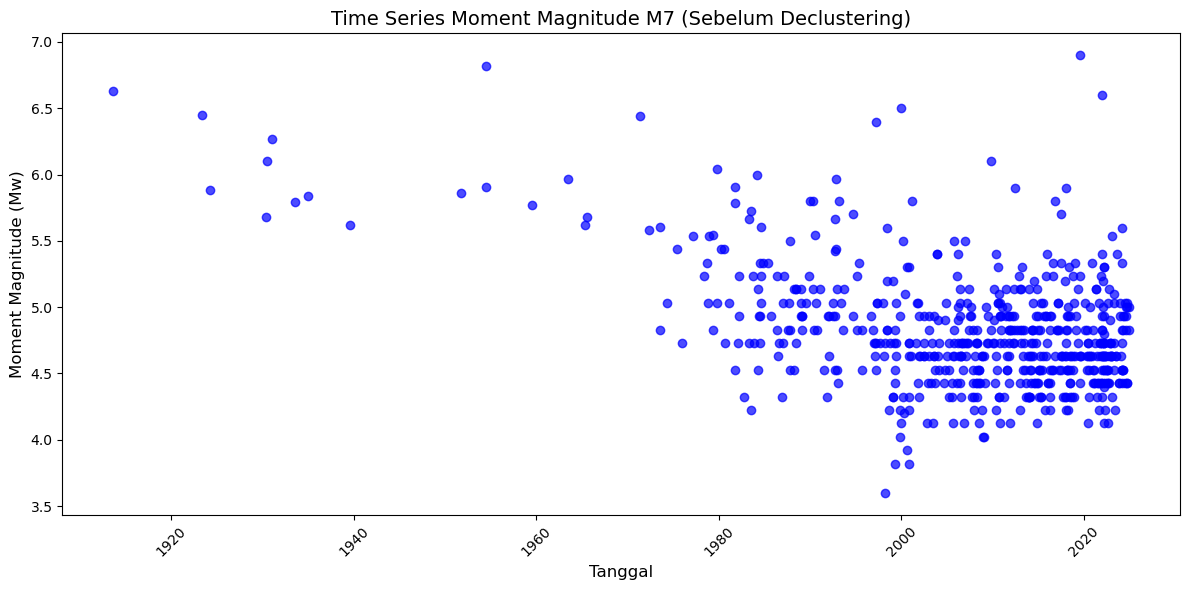

In [15]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df7
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['mag'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Moment Magnitude M7 (Sebelum Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Moment Magnitude (Mw)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_2696\897688590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')


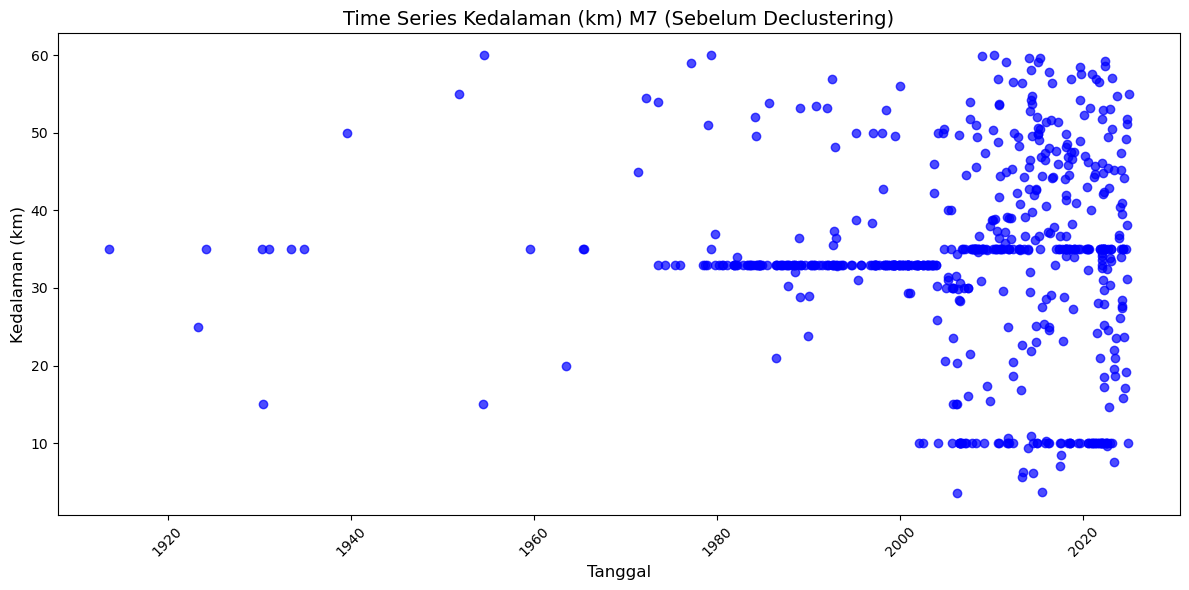

In [16]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df7
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['depth'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Kedalaman (km) M7 (Sebelum Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Kedalaman (km)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

In [17]:
desc_stat(df7)

Waktu terkecil: 1913-08-13 04:25:42.330000+00:00
Waktu terbesar: 2024-12-20 18:22:39.340000+00:00

Descriptive Stats:
         latitude   longitude       depth         mag
count  600.000000  600.000000  600.000000  600.000000
mean    -7.446731  105.702631   33.709085    4.826822
std      0.610728    0.707153   12.641658    0.457560
min     -8.979000  104.036000    3.600000    3.600000
25%     -7.768925  105.143450   30.555250    4.527180
50%     -7.361500  105.789250   33.000000    4.729320
75%     -6.981325  106.245575   39.840000    5.032530
max     -6.337000  107.083000   60.000000    6.900000

Banyaknya kolom dan baris:
(600, 22)


## Declustering

Data shape before declustering

In [18]:
df7.shape

(600, 22)

Declustering and data shape after declustering

In [19]:
df7 = declustering(df7)
df7.shape

C:\Users\user\AppData\Local\Temp\ipykernel_2696\3437048214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mag'] = df.apply(conversion, axis=1)


(384, 25)

### Statistic Descriptive (After Declustering)

In [20]:
desc_stat(df7)

Waktu terkecil: 1913-08-13 04:25:42.330000+00:00
Waktu terbesar: 2024-12-20 18:22:39.340000+00:00

Descriptive Stats:
         latitude   longitude       depth         mag
count  384.000000  384.000000  384.000000  384.000000
mean    -7.529515  105.756749   34.126779    4.903645
std      0.634545    0.746216   12.986640    0.494176
min     -8.979000  104.036000    3.600000    3.819690
25%     -7.901800  105.191300   31.116250    4.628250
50%     -7.480500  105.899700   33.000000    4.830390
75%     -7.042625  106.371500   42.065000    5.133600
max     -6.337000  107.083000   60.000000    6.900000

Banyaknya kolom dan baris:
(384, 25)


## Data Visualization (After Declustering)

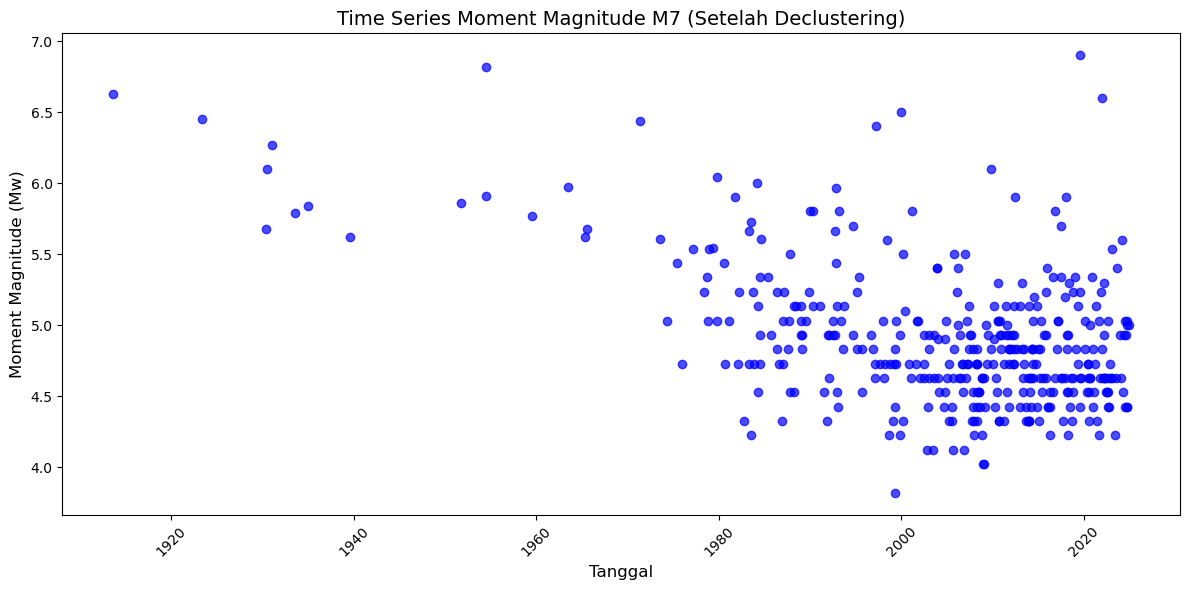

In [21]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df7
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['mag'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Moment Magnitude M7 (Setelah Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Moment Magnitude (Mw)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

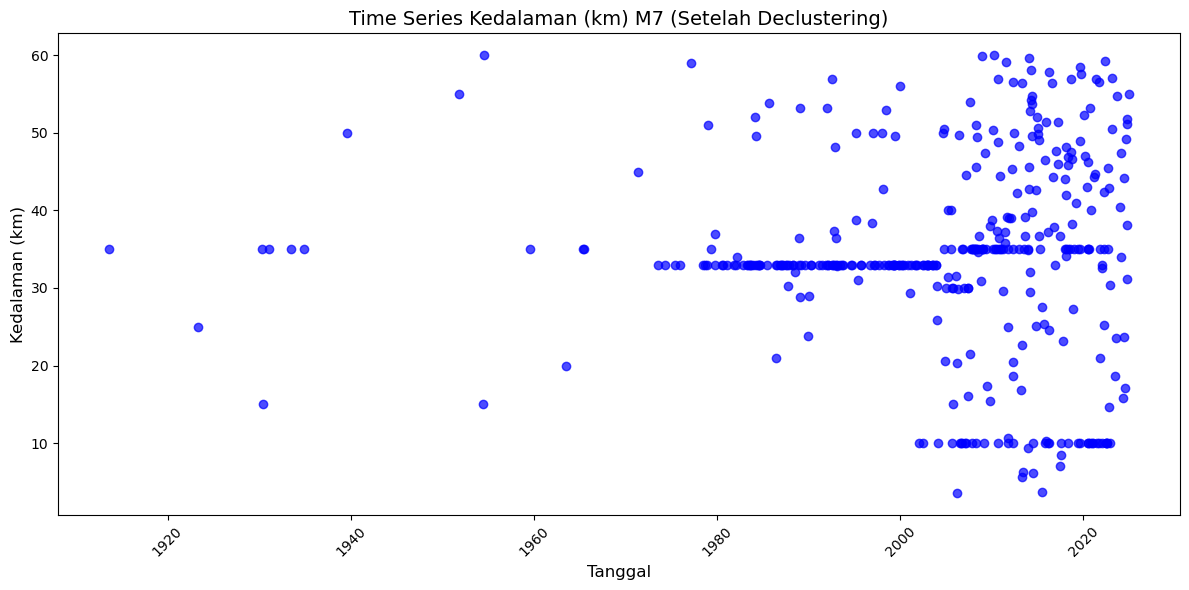

In [22]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df7
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['depth'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Kedalaman (km) M7 (Setelah Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Kedalaman (km)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

## Save File

In [23]:
# Buat baris baris baru
new_rows = pd.DataFrame({
    'mag': [8.1, 7.8],
    'date': ['27/02/1903', '17/07/2006'],  # format sama dengan data lain
})

# Pastikan kolom lain sama dengan df7
for col in df7.columns:
    if col not in new_rows.columns:
        new_rows[col] = np.nan

# Urutkan kolom agar sama dengan df7
new_rows = new_rows[df7.columns]

# Gabungkan ke df7
df7 = pd.concat([df7, new_rows], ignore_index=True)

# Simpan ke CSV
df7.to_csv("M7 Declustering.csv", index=False)

# Megathrust West-Central Java (M8)

In [24]:
df8 = pd.read_csv('../Data/Data M8.csv')

In [25]:
df8

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024/12/02 12:40:01.744+00,-7.9808,107.0044,22.973,4.60,mb,45.0,91.0,0.821,1.09,...,2025/02/15 18:28:58.040+00,"98 km SSW of Banjar, Indonesia",earthquake,6.90,5.555,0.093,34.0,reviewed,us,us
1,2024/11/19 12:28:14.019+00,-8.1086,107.4066,48.061,4.60,mb,45.0,48.0,0.686,0.34,...,2025/01/30 17:00:35.040+00,"101 km S of Banjar, Indonesia",earthquake,6.70,6.874,0.088,39.0,reviewed,us,us
2,2024/11/01 08:33:53.328+00,-9.3289,108.8595,10.000,4.60,mb,26.0,80.0,2.207,1.01,...,2025/01/16 18:46:14.040+00,"178 km S of Cilacap, Indonesia",earthquake,6.05,1.901,0.129,18.0,reviewed,us,us
3,2024/10/31 17:48:01.249+00,-9.2490,108.9052,24.387,4.70,mb,34.0,125.0,2.166,0.75,...,2025/01/16 18:48:57.040+00,"168 km S of Cilacap, Indonesia",earthquake,7.73,3.620,0.115,23.0,reviewed,us,us
4,2024/09/06 23:25:30.525+00,-8.2792,106.8010,27.190,4.40,mb,23.0,104.0,1.169,0.35,...,2024/11/15 16:20:12.040+00,"138 km SSW of Banjar, Indonesia",earthquake,6.98,5.830,0.143,14.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,1943/07/23 14:53:09.890+00,-8.6210,109.8420,60.000,7.44,mw,NaN,NaN,NaN,NaN,...,2022/04/26 19:12:40.568+00,"87 km SSW of Srandakan, Indonesia",earthquake,NaN,5.400,0.300,NaN,reviewed,iscgem,iscgem
719,1940/12/08 06:11:00.200+00,-9.1080,108.1780,35.000,5.88,mw,NaN,NaN,NaN,NaN,...,2022/04/26 19:40:27.027+00,"190 km S of Kawalu, Indonesia",earthquake,NaN,4.500,0.410,NaN,reviewed,iscgem,iscgem
720,1937/12/17 04:26:25.110+00,-9.0920,106.5920,15.000,5.56,mw,NaN,NaN,NaN,NaN,...,2022/04/25 21:18:58.119+00,"229 km SSW of Banjar, Indonesia",earthquake,NaN,6.200,0.290,NaN,reviewed,iscgem,iscgem
721,1927/09/08 23:22:48.120+00,-8.1260,107.3510,35.000,5.77,mw,NaN,NaN,NaN,NaN,...,2022/04/25 23:09:00.110+00,"103 km S of Banjar, Indonesia",earthquake,NaN,14.500,0.260,NaN,reviewed,iscgem,iscgem


## Statistic Descriptive (Before Processing)

In [26]:
desc_stat(df8)

Waktu terkecil: 1919/04/24 17:10:45.820+00
Waktu terbesar: 2024/12/02 12:40:01.744+00

Descriptive Stats:
         latitude   longitude       depth         mag
count  723.000000  723.000000  723.000000  723.000000
mean    -8.819177  108.020690   27.238295    4.536266
std      0.636336    0.719646   14.869980    0.850833
min     -9.993000  106.510000    0.800000    0.000000
25%     -9.331500  107.470000   10.000000    4.300000
50%     -9.052000  107.922000   33.000000    4.600000
75%     -8.168100  108.529500   35.000000    4.900000
max     -7.343000  109.842000   60.000000    7.700000

Banyaknya kolom dan baris:
(723, 22)


## Moment Magnitude Conversion

In [27]:
df8['magType'].unique()

array(['mb', 'mww', 'mwb', 'mwc', nan, 'ms', 'mw'], dtype=object)

In [28]:
df8['mag']     = df8.apply(conversion, axis=1)
df8['magType'] = df8['magType'].replace(['mb', 'mwr', 'mww', 'mwb', 'mwc', 'ms', 'md', 'ml'], 'mw')

### Statistic Descriptive (After Conversion)

In [29]:
desc_stat(df8)

Waktu terkecil: 1919/04/24 17:10:45.820+00
Waktu terbesar: 2024/12/02 12:40:01.744+00

Descriptive Stats:
         latitude   longitude       depth         mag
count  723.000000  723.000000  723.000000  723.000000
mean    -8.819177  108.020690   27.238295    4.653293
std      0.636336    0.719646   14.869980    0.858476
min     -9.993000  106.510000    0.800000    0.000000
25%     -9.331500  107.470000   10.000000    4.426110
50%     -9.052000  107.922000   33.000000    4.729320
75%     -8.168100  108.529500   35.000000    5.000000
max     -7.343000  109.842000   60.000000    7.700000

Banyaknya kolom dan baris:
(723, 22)


Removing the Mw = 0

In [30]:
df8 = df8[df8['mag'] !=0]

## Data Visualization (Before Declustering)

C:\Users\user\AppData\Local\Temp\ipykernel_2696\1685525069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')


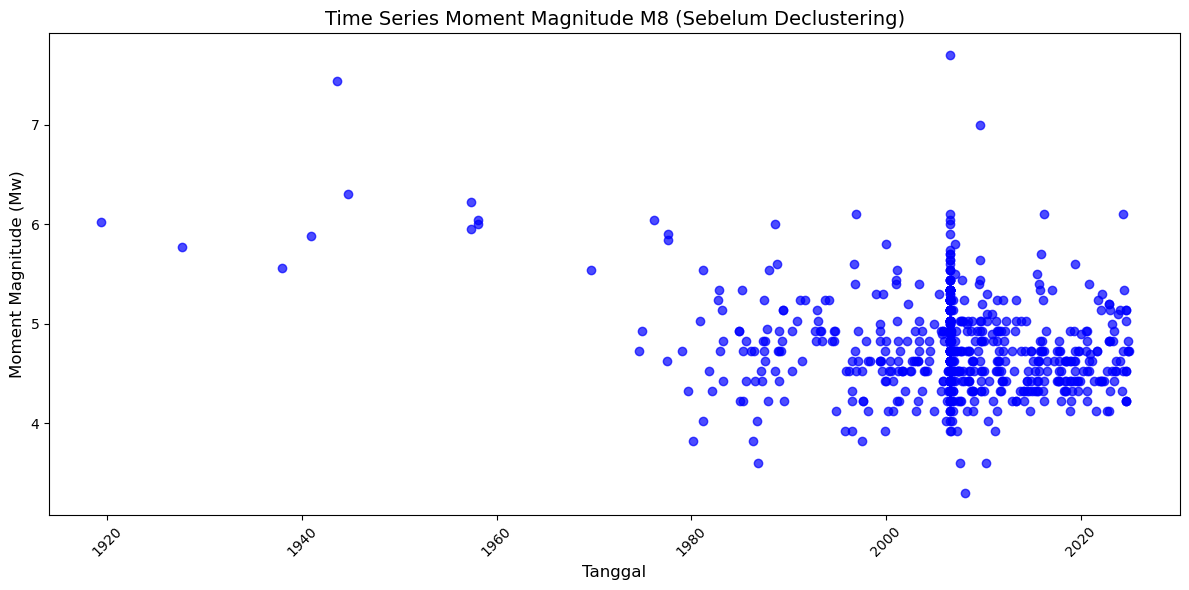

In [31]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df8
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['mag'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Moment Magnitude M8 (Sebelum Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Moment Magnitude (Mw)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_2696\695780851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')


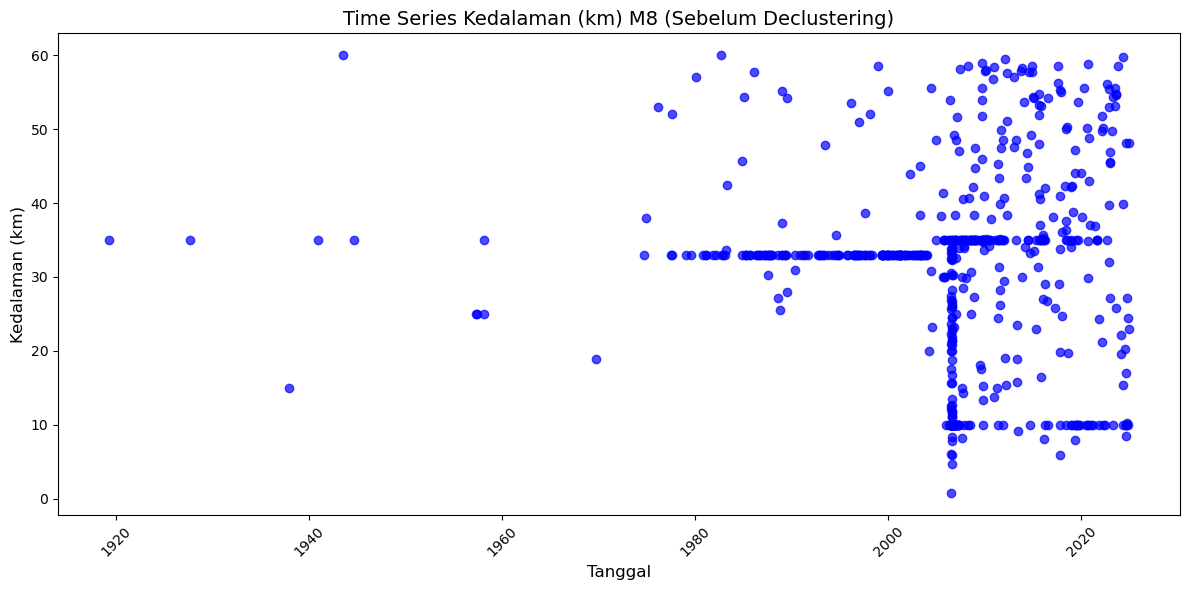

In [32]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df8
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['depth'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Kedalaman (km) M8 (Sebelum Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Kedalaman (km)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

In [33]:
desc_stat(df8)

Waktu terkecil: 1919-04-24 17:10:45.820000+00:00
Waktu terbesar: 2024-12-02 12:40:01.744000+00:00

Descriptive Stats:
         latitude   longitude       depth         mag
count  706.000000  706.000000  706.000000  706.000000
mean    -8.818485  108.011971   27.392758    4.765341
std      0.634425    0.718780   14.886861    0.469092
min     -9.993000  106.510000    0.800000    3.300000
25%     -9.330000  107.453450   10.000000    4.426110
50%     -9.052000  107.903350   33.000000    4.729320
75%     -8.166150  108.521000   35.000000    5.032530
max     -7.343000  109.842000   60.000000    7.700000

Banyaknya kolom dan baris:
(706, 22)


## Declustering

Data shape before declustering

In [34]:
df8.shape

(706, 22)

Declustering and data shape after declustering

In [35]:
df8 = declustering(df8)
df8.shape

C:\Users\user\AppData\Local\Temp\ipykernel_2696\3437048214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mag'] = df.apply(conversion, axis=1)


(332, 25)

### Statistic Descriptive (After Declustering)

In [36]:
desc_stat(df8)

Waktu terkecil: 1919-04-24 17:10:45.820000+00:00
Waktu terbesar: 2024-10-31 17:48:01.249000+00:00

Descriptive Stats:
         latitude   longitude       depth         mag
count  332.000000  332.000000  332.000000  332.000000
mean    -8.649805  108.025230   33.411295    4.787683
std      0.643482    0.833173   12.655246    0.540728
min     -9.993000  106.510000    5.920000    3.300000
25%     -9.221000  107.397400   30.675000    4.426110
50%     -8.678500  107.870850   33.000000    4.729320
75%     -8.068250  108.623800   38.180000    5.032530
max     -7.492000  109.842000   60.000000    7.700000

Banyaknya kolom dan baris:
(332, 25)


## Data Visualization (After Declustering)

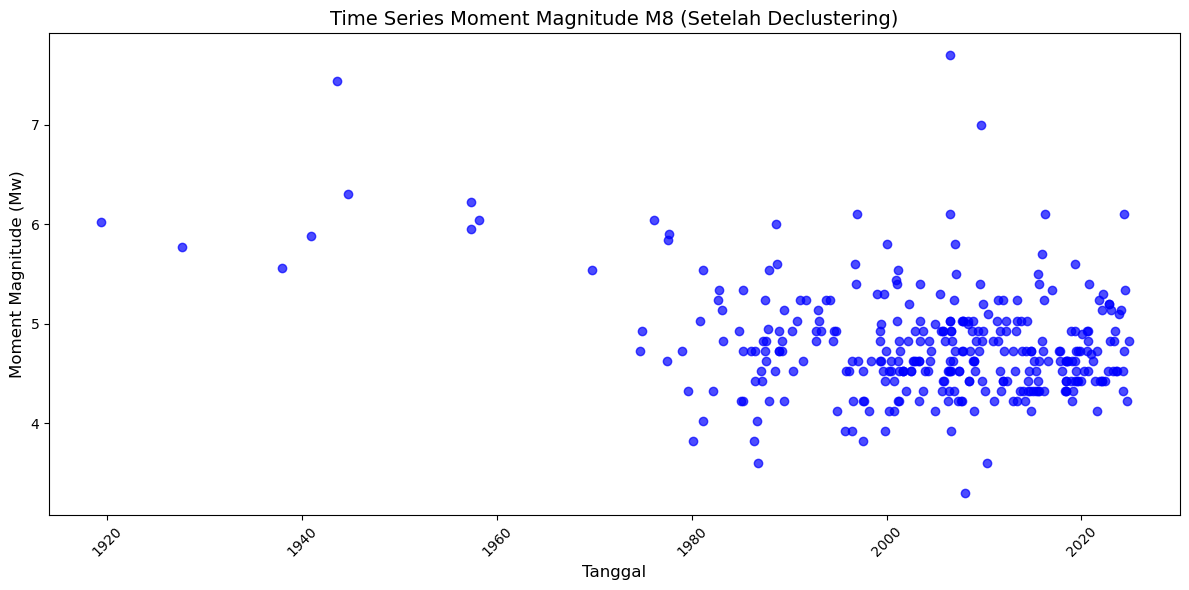

In [37]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df8
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['mag'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Moment Magnitude M8 (Setelah Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Moment Magnitude (Mw)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

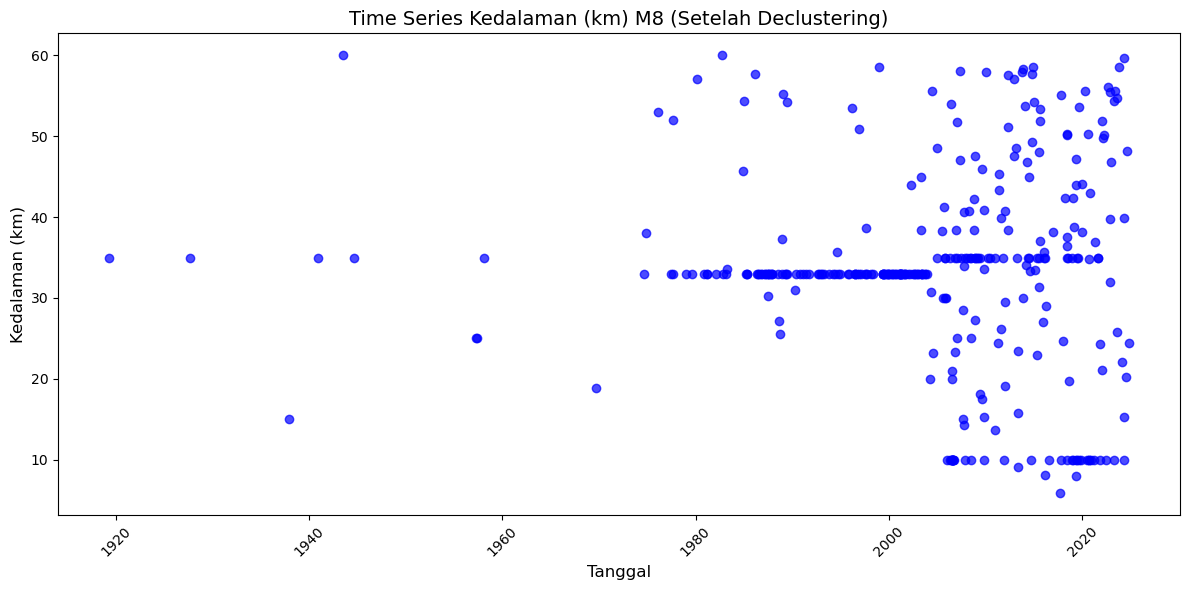

In [38]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df8
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['depth'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Kedalaman (km) M8 (Setelah Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Kedalaman (km)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

## Save File

In [39]:
# Buat baris baris baru
new_rows = pd.DataFrame({
    'mag': [8.1, 7.2],
    'date': ['30/06/1921', '27/09/1937'],  # format sama dengan data lain
})

# Pastikan kolom lain sama dengan df8
for col in df8.columns:
    if col not in new_rows.columns:
        new_rows[col] = np.nan

# Urutkan kolom agar sama dengan df8
new_rows = new_rows[df8.columns]

# Gabungkan ke df8
df8 = pd.concat([df8, new_rows], ignore_index=True)

# Simpan ke CSV
df8.to_csv("M8 Declustering.csv", index=False)

# Megathrust East Java (M9)

In [40]:
df9 = pd.read_csv('../Data/Data M9.csv')

In [41]:
df9

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024/12/13 17:39:26.685+00,-9.3859,112.8291,55.91,4.40,mb,47.0,65.0,1.593,0.78,...,2025/02/18 20:02:58.040+00,"130 km S of Dampit, Indonesia",earthquake,5.34,6.915,0.098,38.0,reviewed,us,us
1,2024/12/10 20:11:22.897+00,-9.7806,112.1863,10.00,4.40,mb,33.0,125.0,2.337,0.74,...,2025/02/18 20:02:54.040+00,"182 km S of Sumberpucung, Indonesia",earthquake,8.52,1.891,0.114,22.0,reviewed,us,us
2,2024/12/02 16:06:10.719+00,-9.5851,110.2390,10.00,4.50,mb,44.0,115.0,2.527,1.11,...,2025/02/15 18:28:59.040+00,"180 km S of Bambanglipuro, Indonesia",earthquake,7.72,1.639,0.111,24.0,reviewed,us,us
3,2024/11/17 23:26:48.458+00,-9.4678,113.8784,48.28,4.50,mb,38.0,110.0,1.028,0.60,...,2025/01/26 16:31:18.040+00,"122 km SSW of Gambiran Satu, Indonesia",earthquake,6.88,7.510,0.106,26.0,reviewed,us,us
4,2024/09/23 16:19:10.583+00,-10.6276,113.3531,10.00,4.40,mb,27.0,94.0,2.284,0.75,...,2024/12/06 19:30:12.040+00,"259 km S of Kencong, Indonesia",earthquake,5.29,1.919,0.134,16.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,1926/09/11 12:27:35.190+00,-9.6350,110.3500,35.00,6.02,mw,NaN,NaN,NaN,NaN,...,2022/04/25 23:19:32.649+00,"186 km S of Pundong, Indonesia",earthquake,NaN,25.000,0.210,NaN,reviewed,iscgem,iscgem
840,1926/09/10 10:34:28.090+00,-9.1690,110.6300,35.00,7.10,mw,NaN,NaN,NaN,NaN,...,2022/04/25 23:19:27.230+00,"138 km SSE of Pundong, Indonesia",earthquake,NaN,15.400,0.280,NaN,reviewed,iscgem,iscgem
841,1921/09/11 04:01:45.060+00,-10.0460,110.6530,15.00,7.58,mw,NaN,NaN,NaN,NaN,...,2022/04/25 23:44:36.636+00,"233 km S of Pundong, Indonesia",earthquake,NaN,25.000,0.350,NaN,reviewed,iscgem,iscgem
842,1918/08/31 21:53:52.650+00,-9.4000,109.8790,35.00,6.23,mw,NaN,NaN,NaN,NaN,...,2022/04/25 23:56:40.180+00,"166 km SSW of Bambanglipuro, Indonesia",earthquake,NaN,25.000,0.360,NaN,reviewed,iscgem,iscgem


## Statistic Descriptive (Before Processing)

In [42]:
desc_stat(df9)

Waktu terkecil: 1910/07/07 08:16:42.160+00
Waktu terbesar: 2024/12/13 17:39:26.685+00

Descriptive Stats:
         latitude   longitude       depth         mag
count  844.000000  844.000000  844.000000  844.000000
mean    -9.654306  112.363082   34.921637    4.491280
std      0.501883    1.224557   13.215221    0.838837
min    -10.750000  109.708000    2.000000    0.000000
25%     -9.944825  111.422500   33.000000    4.200000
50%     -9.580600  112.786150   33.000000    4.500000
75%     -9.283275  113.318250   42.625000    4.800000
max     -8.643000  114.190100   60.000000    7.800000

Banyaknya kolom dan baris:
(844, 22)


## Moment Magnitude Conversion

In [43]:
df9['magType'].unique()

array(['mb', 'mww', 'mwr', 'mwc', nan, 'no', 'mwb', 'ml', 'md', 'ms',
       'mw'], dtype=object)

In [44]:
df9['mag']     = df9.apply(conversion, axis=1)
df9['magType'] = df9['magType'].replace(['mb', 'mwr', 'mww', 'mwb', 'mwc', 'ms', 'md', 'ml'], 'mw')

### Statistic Descriptive (After Conversion)

In [45]:
desc_stat(df9)

Waktu terkecil: 1910/07/07 08:16:42.160+00
Waktu terbesar: 2024/12/13 17:39:26.685+00

Descriptive Stats:
         latitude   longitude       depth         mag
count  844.000000  844.000000  844.000000  844.000000
mean    -9.654306  112.363082   34.921637    4.603770
std      0.501883    1.224557   13.215221    0.844959
min    -10.750000  109.708000    2.000000    0.000000
25%     -9.944825  111.422500   33.000000    4.325040
50%     -9.580600  112.786150   33.000000    4.628250
75%     -9.283275  113.318250   42.625000    4.931460
max     -8.643000  114.190100   60.000000    7.800000

Banyaknya kolom dan baris:
(844, 22)


Removing the Mw = 0

In [46]:
df9 = df9[df9['mag'] !=0]

## Data Visualization (Before Declustering)

C:\Users\user\AppData\Local\Temp\ipykernel_2696\13573325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')


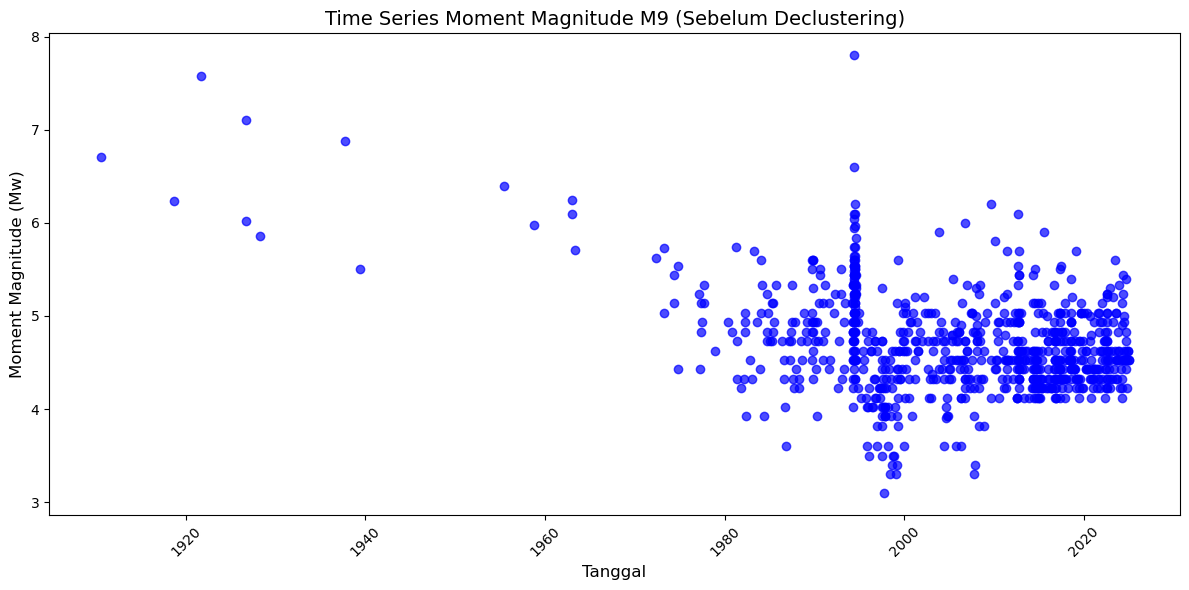

In [47]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df9
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['mag'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Moment Magnitude M9 (Sebelum Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Moment Magnitude (Mw)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_2696\1981713587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')


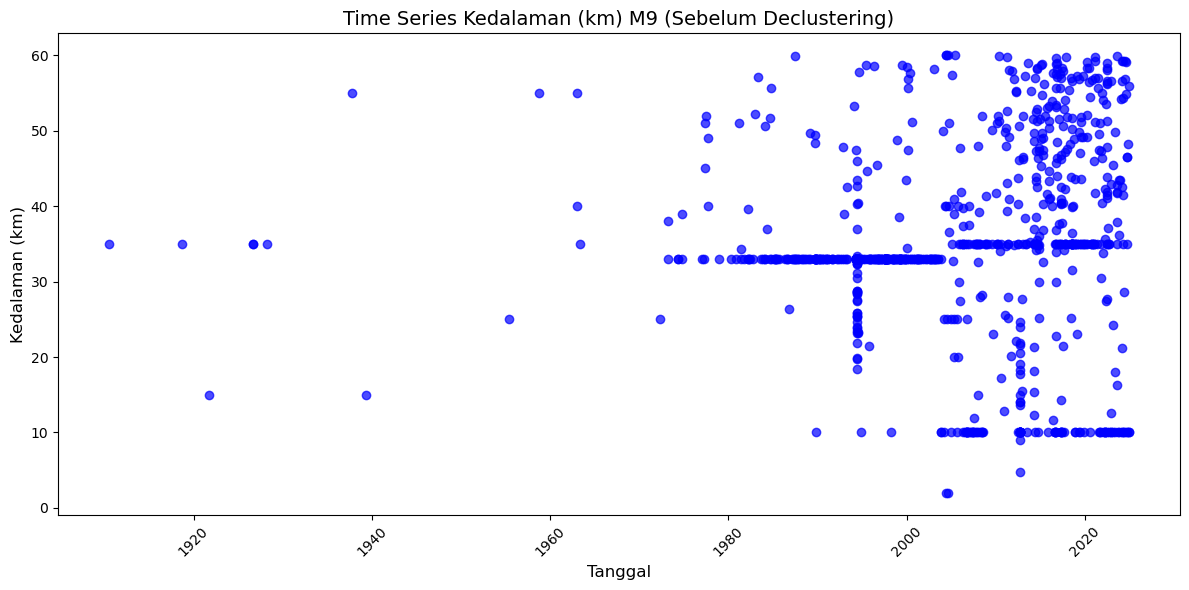

In [48]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df9
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['depth'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Kedalaman (km) M9 (Sebelum Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Kedalaman (km)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

In [49]:
desc_stat(df9)

Waktu terkecil: 1910-07-07 08:16:42.160000+00:00
Waktu terbesar: 2024-12-13 17:39:26.685000+00:00

Descriptive Stats:
         latitude   longitude       depth         mag
count  827.000000  827.000000  827.000000  827.000000
mean    -9.657165  112.364318   35.000075    4.698406
std      0.502038    1.227576   13.249952    0.532421
min    -10.750000  109.708000    2.000000    3.100000
25%     -9.945650  111.422000   33.000000    4.325040
50%     -9.585000  112.790000   33.000000    4.628250
75%     -9.288350  113.322650   42.860500    5.000000
max     -8.643000  114.190100   60.000000    7.800000

Banyaknya kolom dan baris:
(827, 22)


## Declustering

Data shape before declustering

In [50]:
df9.shape

(827, 22)

Declustering and data shape after declustering

In [51]:
df9 = declustering(df9)
df9.shape

C:\Users\user\AppData\Local\Temp\ipykernel_2696\3437048214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mag'] = df.apply(conversion, axis=1)


(469, 25)

### Statistic Descriptive (After Declustering)

In [52]:
desc_stat(df9)

Waktu terkecil: 1910-07-07 08:16:42.160000+00:00
Waktu terbesar: 2024-12-13 17:39:26.685000+00:00

Descriptive Stats:
         latitude   longitude       depth         mag
count  469.000000  469.000000  469.000000  469.000000
mean    -9.559956  112.220766   35.580296    4.703834
std      0.472213    1.292507   13.831049    0.565469
min    -10.741000  109.708000    2.000000    3.100000
25%     -9.806000  111.139700   33.000000    4.325040
50%     -9.484400  112.523000   33.000000    4.628250
75%     -9.215700  113.264000   46.420000    5.000000
max     -8.643000  114.171600   60.000000    7.800000

Banyaknya kolom dan baris:
(469, 25)


## Data Visualization (After Declustering)

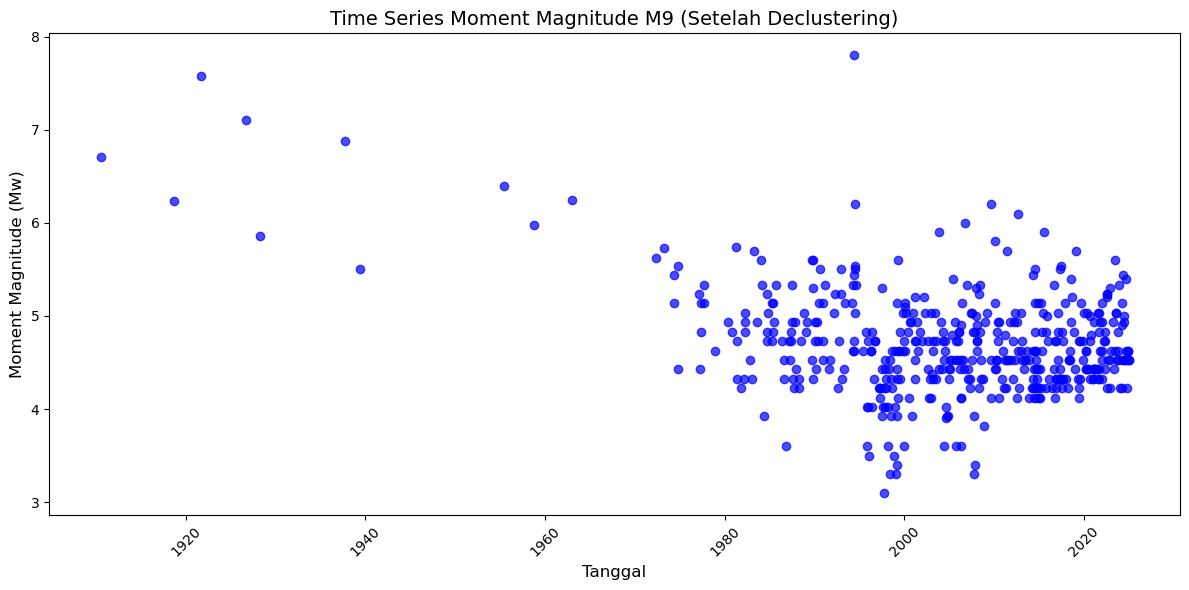

In [53]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df9
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['mag'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Moment Magnitude M9 (Setelah Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Moment Magnitude (Mw)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

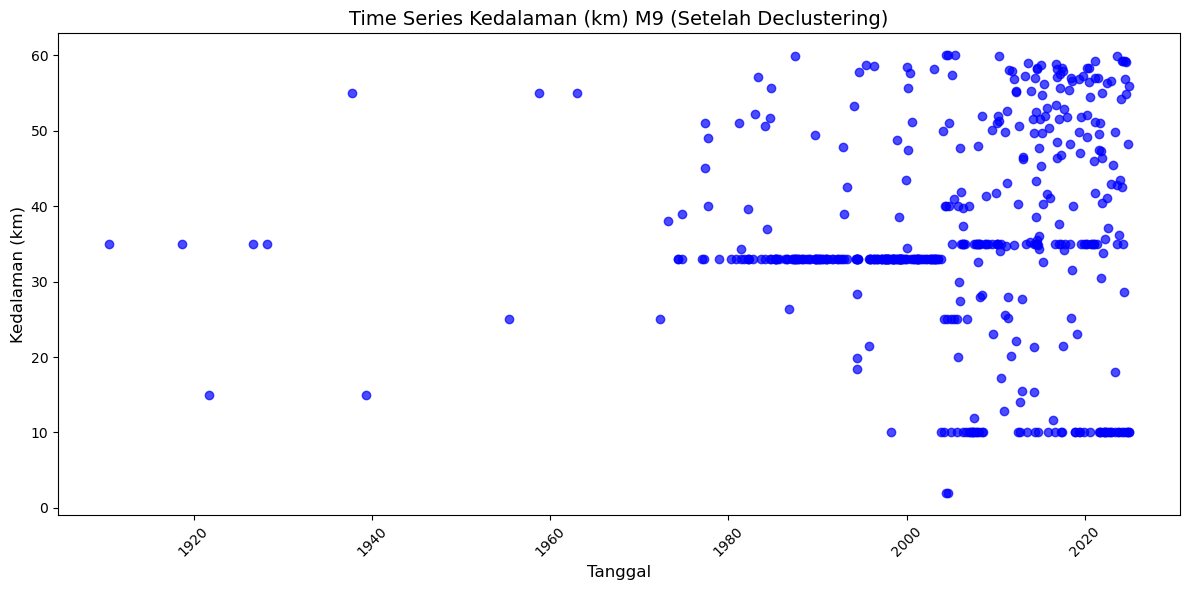

In [54]:
# Pastikan kolom 'time' sudah dalam format datetime
df1 = df9
df1['time'] = pd.to_datetime(df1['time'], format='ISO8601', errors='coerce')

# Membuat grafik time series tanpa garis
plt.figure(figsize=(12, 6))
plt.scatter(df1['time'], df1['depth'], color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title('Time Series Kedalaman (km) M9 (Setelah Declustering)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Kedalaman (km)', fontsize=12)

# Menyesuaikan tampilan sumbu-X
plt.xticks(rotation=45)

# Menampilkan grafik
plt.tight_layout()
plt.show()

## Save File

In [55]:
# Buat baris baris baru
new_rows = pd.DataFrame({
    'mag': [7.2],
    'date': ['09/09/1916'],  # format sama dengan data lain
})

# Pastikan kolom lain sama dengan df9
for col in df9.columns:
    if col not in new_rows.columns:
        new_rows[col] = np.nan

# Urutkan kolom agar sama dengan df9
new_rows = new_rows[df9.columns]

# Gabungkan ke df9
df9 = pd.concat([df9, new_rows], ignore_index=True)

# Simpan ke CSV
df9.to_csv("M9 Declustering.csv", index=False)